**teneva** (demo)

---

# Introduction

This python package, named teneva (**ten**sor **eva**luation), provides very compact implementation for the multidimensional cross approximation algorithm in the tensor-train (TT) format. This package also contains a function for quickly calculating the values of the constructed low-rank tensor approximation, as well as a number of auxiliary useful utilities.

> See [github repo](https://github.com/AndreiChertkov/teneva) for more details and the License file.

> Below, we provide a brief description and demonstration of the capabilities of each function from the `teneva` package. The program code is organized within a functional paradigm. Most functions take $Y$ - a list of the TT-cores $G_1, G_2, \ldots, G_d$ (3D numpy arrays) - as an input argument and return its updated representation as a new list of TT-cores or some related scalar values (mean, norm, etc.). Sometimes to demonstrate a specific function, it is also necessary to use some other functions from the package, in this case we do not provide comments for the auxiliary function, however all relevant information can be found in the relevant subsection.

# Loading and importing modules

In [1]:
import numpy as np
import teneva
from time import perf_counter as tpc
np.random.seed(42)

# Modules, functions and classes of `teneva.core`

## Module `als`

This module contains the function `als` which computes the TT-approximation for the tensor by TT-ALS algorithm, using given random samples.

### Function `als`

Build TT-tensor by TT-ALS from the given random tensor samples.

In [2]:
d         = 10          # Dimension of the function
A         = [-2.] * d   # Lower bound for spatial grid
B         = [+2.] * d   # Upper bound for spatial grid
N         = [10] * d    # Shape of the tensor (it may be non-uniform)
M_tst     = 10000       # Number of test points

In [9]:
evals     = 10000       # Number of calls to target function
nswp      = 50          # Sweep number for ALS iterations
r         = 3           # TT-rank of the initial random tensor

In [10]:
# Target function
# (the function takes as input a set of tensor indices I of the shape [samples, dim], which
# are transformed into points X of a uniform spatial grid using the function "ind2poi"):

from scipy.optimize import rosen
def func(I): 
    X = teneva.ind2poi(I, A, B, N)
    return rosen(X.T)

In [11]:
# Train data:

I_trn = teneva.sample_lhs(N, evals) 
Y_trn = func(I_trn)

In [12]:
# Test data
# (we generate M_tst random tensor elements for accuracy check):

I_tst = np.vstack([np.random.choice(N[i], M_tst) for i in range(d)]).T
Y_tst = func(I_tst)

In [13]:
# Build tensor
# (we generate random initial r-rank approximation in the TT-format using
# the function "rand") and then compute the resulting TT-tensor by TT-ALS):

t = tpc()
Y = teneva.rand(N, r)
Y = teneva.als(I_trn, Y_trn, Y, nswp)
t = tpc() - t

print(f'Build time     : {t:-10.2f}')

Build time     :       3.17


In [14]:
# Check result:

get = teneva.getter(Y)

Z = np.array([get(i) for i in I_trn])
e_trn = np.linalg.norm(Z - Y_trn) / np.linalg.norm(Y_trn)

Z = np.array([get(i) for i in I_tst])
e_tst = np.linalg.norm(Z - Y_tst) / np.linalg.norm(Y_tst)

print(f'Error on train : {e_trn:-10.2e}')
print(f'Error on test  : {e_tst:-10.2e}')

Error on train :   8.44e-01
Error on test  :   3.91e+00


### Function `als2`

Build TT-tensor by TT-ALS from the given random tensor samples. This is the alternative realization of the algorithm. The version from "als" function in many cases works better.

In [21]:
d         = 5           # Dimension of the function
A         = [-2.] * d   # Lower bound for spatial grid
B         = [+2.] * d   # Upper bound for spatial grid
N         = [10] * d    # Shape of the tensor (it may be non-uniform)
M_tst     = 10000       # Number of test points

In [22]:
evals     = 10000       # Number of calls to target function
nswp      = 50          # Sweep number for ALS iterations
r         = 3           # TT-rank of the initial random tensor

In [23]:
# Target function
# (the function takes as input a set of tensor indices I of the shape [samples, dim], which
# are transformed into points X of a uniform spatial grid using the function "ind2poi"):

from scipy.optimize import rosen
def func(I): 
    X = teneva.ind2poi(I, A, B, N)
    return rosen(X.T)

In [24]:
# Train data:

I_trn = teneva.sample_lhs(N, evals) 
Y_trn = func(I_trn)

In [25]:
# Test data
# (we generate M_tst random tensor elements for accuracy check):

I_tst = np.vstack([np.random.choice(N[i], M_tst) for i in range(d)]).T
Y_tst = func(I_tst)

In [26]:
# Build tensor
# (we generate random initial r-rank approximation in the TT-format using
# the function "rand") and then compute the resulting TT-tensor by TT-ALS):

t = tpc()
Y = teneva.rand(N, r)
Y = teneva.als2(I_trn, Y_trn, Y, nswp)
t = tpc() - t

print(f'Build time     : {t:-10.2f}')

Build time     :     106.83


In [27]:
# Check result:

get = teneva.getter(Y)

Z = np.array([get(i) for i in I_trn])
e_trn = np.linalg.norm(Z - Y_trn) / np.linalg.norm(Y_trn)

Z = np.array([get(i) for i in I_tst])
e_tst = np.linalg.norm(Z - Y_tst) / np.linalg.norm(Y_tst)

print(f'Error on train : {e_trn:-10.2e}')
print(f'Error on test  : {e_tst:-10.2e}')

Error on train :   1.54e-15
Error on test  :   1.60e-15


## Module `anova`

This module contains the function "anova" which computes the TT-approximation for the tensor, using given random samples.

### Function `anova`

Construct TT-ANOVA from the given random tensor samples.

In [28]:
d         = 10          # Dimension of the function
A         = [-5.] * d   # Lower bound for spatial grid
B         = [+5.] * d   # Upper bound for spatial grid
N         = [10] * d    # Shape of the tensor (it may be non-uniform)
M_tst     = 10000       # Number of test points

In [29]:
evals     = 10000       # Number of calls to target function
order     = 1           # Order of ANOVA decomposition (1 or 2)
r         = 3           # TT-rank of the resulting tensor

In [30]:
# Target function:

from scipy.optimize import rosen
def func(I): 
    X = teneva.ind2poi(I, A, B, N)
    return rosen(X.T)

In [31]:
# Train data:

I_trn = teneva.sample_lhs(N, evals) 
Y_trn = func(I_trn)

In [32]:
# Test data:

I_tst = np.vstack([np.random.choice(N[i], M_tst) for i in range(d)]).T
Y_tst = func(I_tst)

In [33]:
# Build tensor:

t = tpc()
Y = teneva.anova(I_trn, Y_trn, r, order)
t = tpc() - t

print(f'Build time     : {t:-10.2f}')

Build time     :       0.01


In [34]:
# Check result:

get = teneva.getter(Y)

Z = np.array([get(i) for i in I_trn])
e_trn = np.linalg.norm(Z - Y_trn) / np.linalg.norm(Y_trn)

Z = np.array([get(i) for i in I_tst])
e_tst = np.linalg.norm(Z - Y_tst) / np.linalg.norm(Y_tst)

print(f'Error on train : {e_trn:-10.2e}')
print(f'Error on test  : {e_tst:-10.2e}')

Error on train :   9.59e-02
Error on test  :   9.68e-02


## Module `cheb`

This module contains the functions for construction of the Chebyshev interpolation in the TT-format as well as calculating the values of the function using the constructed interpolation coefficients.

### Function `cheb_bld`

Compute the function values on the Chebyshev grid using TT-CAM.

In [2]:
from scipy.optimize import rosen
f = lambda X: rosen(X.T)                  # Target function

a = [-2., -4., -3., -2.]                  # Grid lower bounds
b = [+2., +3., +4., +2.]                  # Grid upper bounds
n = [5, 6, 7, 8]                          # Grid size
Y0 = teneva.rand(n, r=2)                  # Initial approximation for TT-CAM
e = 1.E-3                                 # Accuracy for TT-CAM
Y = teneva.cheb_bld(f, a, b, n,           # TT-tensor of values on the Cheb. grid
    Y0=Y0, e=e)                           # TT-CAM arguments (Y0 and e are required)
teneva.show(Y)                            # Show the result

  5  6  7  8 
 / \/ \/ \/ \
 1  3  3  3  1 



### Function `cheb_get`

Compute the Chebyshev approximation in given points (approx. f(X)).

In [4]:
# In the beginning we compute the function values on the Chebyshev grid using TT-CAM
# (see teneva.core.cheb.cheb_bld function for more details):

from scipy.optimize import rosen
f = lambda X: rosen(X.T)                  # Target function

a = [-2., -4., -3., -2.]                  # Grid lower bounds
b = [+2., +3., +4., +2.]                  # Grid upper bounds
n = [5, 6, 7, 8]                          # Grid size
Y0 = teneva.rand(n, r=2)                  # Initial approximation for TT-CAM
e = 1.E-3                                 # Accuracy for TT-CAM
Y = teneva.cheb_bld(f, a, b, n,           # TT-tensor of values on the Cheb. grid
    Y0=Y0, e=e)                           # TT-CAM arguments
teneva.show(Y)                            # Show the result

  5  6  7  8 
 / \/ \/ \/ \
 1  3  3  3  1 



In [3]:
# Then we should compute the TT-tensor for Chebyshev interpolation coefficients
# (see teneva.core.cheb.cheb_int function for more details):

A = teneva.cheb_int(Y, e)
teneva.show(A)                            # Show the result

  5  6  7  8 
 / \/ \/ \/ \
 1  3  3  3  1 



In [6]:
# Finally we compute the approximation in selected points inside the bounds:
# (the values for points outside the bounds will be set as "z")

X = np.array([
    [0., 0., 0., 0.],
    [0., 2., 3., 2.],
    [1., 1., 1., 1.],
    [1., 1., 1., 99999999],
])
Z = teneva.cheb_get(X, A, a, b, z=-1.)
print(Z)       # Print the result
print(f(X))    # We can check the result by comparing it to the true values

[ 3.00000000e+00  5.40600000e+03 -2.20268248e-12 -1.00000000e+00]
[3.0000000e+00 5.4060000e+03 0.0000000e+00 9.9999996e+17]


### Function `cheb_get_full`

Compute the Chebyshev approximation (TT-tensor) on the full given grid.

In [2]:
# In the beginning we compute the function values on the Chebyshev grid using TT-CAM
# (see teneva.core.cheb.cheb_bld function for more details):

from scipy.optimize import rosen
f = lambda X: rosen(X.T)                  # Target function

d = 4
a = -2.                                   # Grid lower bounds (it works now only for constant bounds)
b = +3.                                   # Grid upper bounds (it works now only for constant bounds)
n = 5                                     # Grid size (it works now only for constant grid sizes)
Y0 = teneva.rand([n]*d, r=2)              # Initial approximation for TT-CAM
e = 1.E-3                                 # Accuracy for TT-CAM
Y = teneva.cheb_bld(f, a, b, [n]*d,       # TT-tensor of values on the Cheb. grid
    Y0=Y0, e=e)                           # TT-CAM arguments
teneva.show(Y)                            # Show the result

  5  5  5  5 
 / \/ \/ \/ \
 1  3  3  3  1 



In [3]:
# Then we should compute the TT-tensor for Chebyshev interpolation coefficients
# (see teneva.core.cheb.cheb_int function for more details):

A = teneva.cheb_int(Y, e)
teneva.show(A)                            # Show the result

  5  5  5  5 
 / \/ \/ \/ \
 1  3  3  3  1 



In [4]:
m = 10                                    # New size of the grid
Z = teneva.cheb_get_full(A, a, b, m)      # Compute tensor on finer grid
teneva.show(Z)

 10 10 10 10 
 / \/ \/ \/ \
 1  3  3  3  1 



### Function `cheb_int`

Compute the TT-tensor for Chebyshev interpolation coefficients.

In [7]:
# In the beginning we compute the function values on the Chebyshev grid using TT-CAM
# (see teneva.core.cheb.cheb_bld function for more details):

from scipy.optimize import rosen
f = lambda X: rosen(X.T)                  # Target function

a = [-2., -4., -3., -2.]                  # Grid lower bounds
b = [+2., +3., +4., +2.]                  # Grid upper bounds
n = [5, 6, 7, 8]                          # Grid size
Y0 = teneva.rand(n, r=2)                  # Initial approximation for TT-CAM
e = 1.E-3                                 # Accuracy for TT-CAM
Y = teneva.cheb_bld(f, a, b, n,           # TT-tensor of values on the Cheb. grid
    Y0=Y0, e=e)                           # TT-CAM arguments
teneva.show(Y)                            # Show the result

  5  6  7  8 
 / \/ \/ \/ \
 1  3  3  3  1 



In [8]:
# Then we can compute the TT-tensor for Chebyshev interpolation coefficients:

A = teneva.cheb_int(Y, e)
teneva.show(A)                            # Show the result

  5  6  7  8 
 / \/ \/ \/ \
 1  3  3  3  1 



### Function `cheb_pol`

Compute the Chebyshev polynomials in the given points.

In [9]:
a = [-2., -4., -3., -2.]                  # Grid lower bounds
b = [+2., +3., +4., +2.]                  # Grid upper bounds
X = np.array([                            # Two 4-dim points
    [0., 0., 0., 0.],
    [0., 2., 3., 2.],
])
m = 3                                    # Maximum order of polynomial      
T = teneva.cheb_pol(X, a, b, m)          # Compute polynomials

In [10]:
print(T.shape)
print(T[0, 0, 0])                        # 0-th order pol. is 1
print(T[1, 0, 0])                        # 1-th order pol. is x (=0 for x=0)
print(T[2, 0, 0])                        # 2-th order pol. is 2x^2-1 (=-1 for x=0)

(3, 2, 4)
1.0
0.0
-1.0


In [11]:
# Note that grid is scaled from [a, b] limits to [-1, 1] limit:

print(T[0, 1, 3])                        # 0-th order pol. is 1
print(T[1, 1, 3])                        # 1-th order pol. is x (=0 for x=2 with lim [-2, 2])
print(T[2, 1, 3])                        # 2-th order pol. is 2x^2-1 (=-1 for x=2 with lim [-2, 2])

1.0
1.0
1.0


### Function `cheb_sum`

Integrate the function from its Chebyshev approximation in the TT-format.

> Note that this function works only for symmetric grids!

In [12]:
# In the beginning we compute the function values on the Chebyshev grid using TT-CAM
# (see teneva.core.cheb.cheb_bld function for more details):
                 
d = 4
def f(X): # Target function
    a = 2.
    r = np.exp(-np.sum(X*X, axis=1) / a) / (np.pi * a)**(d/2)
    return r.reshape(-1)

a = [-12., -14., -13., -12.]              # Grid lower bounds
b = [+12., +14., +13., +12.]              # Grid upper bounds
n = [50, 50, 50, 50]                      # Grid size
Y0 = teneva.rand(n, r=2)                  # Initial approximation for TT-CAM
e = 1.E-5                                 # Accuracy for TT-CAM
Y = teneva.cheb_bld(f, a, b, n,           # TT-tensor of values on the Cheb. grid
    Y0=Y0, e=e)                           # TT-CAM arguments
teneva.show(Y)                            # Show the result

 50 50 50 50 
 / \/ \/ \/ \
 1  1  1  1  1 



In [13]:
# Then we should compute the TT-tensor for Chebyshev interpolation coefficients
# (see teneva.core.cheb.cheb_int function for more details):

A = teneva.cheb_int(Y, e)
teneva.show(A)                            # Show the result

 50 50 50 50 
 / \/ \/ \/ \
 1  1  1  1  1 



In [14]:
# Finally we compute the integral:

v = teneva.cheb_sum(A, a, b)
print(v)       # Print the result (the real value is 1.)

1.0000000205312076


## Module `cross`

This module computes the TT-approximation for implicit tensor given functionally by multidimensional cross approximation method in the TT-format (TT-CAM).

### Function `cross`

Compute the TT-approximation for implicit tensor given functionally.

In [58]:
d         = 5                           # Dimension of the function
a         = [-5., -4., -3., -2., -1.]   # Lower bounds for spatial grid
b         = [+5., +4., +3., +2., +1.]   # Upper bounds for spatial grid
n         = [ 50,  60,  70,  80,  90]   # Shape of the tensor

In [64]:
evals     = 10000       # Number of calls to target function
nswp      = 4           # Sweep number
dr_min    = 1           # Cross parameter (minimum number of added rows)
dr_max    = 1           # Cross parameter (maximum number of added rows)
r         = 3           # TT-rank of the initial tensor
e         = 1.E-4       # Desired accuracy

In [65]:
# Target function
# (we transform indices into points using "ind2poi" function):

from scipy.optimize import rosen
def func(I): 
    X = teneva.ind2poi(I, a, b, n)
    return rosen(X.T)

In [66]:
# Test data:

m_tst = 10000 # Number of test points
I_tst = np.vstack([np.random.choice(n[i], m_tst) for i in range(d)]).T
Y_tst = func(I_tst)

In [67]:
# Build tensor
# (note: cache is optional (it may be None) and it is effictive only for
# complex functions with long computing time for one call):

t = tpc()
cache, info = {}, {}
Y = teneva.rand(n, r)
Y = teneva.cross(func, Y, e, evals, nswp, dr_min, dr_max, cache, info)
t = tpc() - t

print(f'Build time     : {t:-10.2f}')
print(f'Evals func     : {info["k_evals"]:-10d}')
print(f'Cache uses     : {info["k_cache"]:-10d}')
print(f'Iter accuracy  : {info["e"]:-10.2e}')
print(f'Sweep number   : {info["nswp"]:-10d}')
print(f'Stop condition : {info["stop"]:>10}')
print(f'TT-rank of res : {teneva.erank(Y):-10.1f}')

Build time     :       0.13
Evals func     :       9301
Cache uses     :       2689
Iter accuracy  :  -1.00e+00
Sweep number   :          1
Stop condition :      evals
TT-rank of res :        3.0


In [68]:
# Check result:

get = teneva.getter(Y)                     # Fast getter for TT-tensor values

Z = np.array([get(i) for i in I_tst])      # Compute approximation in test points
e_tst = np.linalg.norm(Z - Y_tst)          # Accuracy of the result
e_tst /= np.linalg.norm(Y_tst)

print(f'Error on test  : {e_tst:-10.2e}')

Error on test  :   8.02e-15


## Module `grid`

Module contains a set of functions for creating and transforming multidimensional grids.

### Function `grid_flat`

Compute the multiindices for the full grid in the form of flat array.

In [3]:
n = [2, 3, 4]
I = teneva.grid_flat(n)
print(I)

[[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 1 1 2 2 0 0 1 1 2 2 0 0 1 1 2 2 0 0 1 1 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3]]


### Function `grid_prep_opts`

Helper function that prepare grid parameters (a, b, n).

In [2]:
d = 3           # Dimension of the tensor/grid
a = -5.         # Lower bounds for grid
b = +5.         # Upper bounds for grid
n = 7           # Shape of the tensor/grid
teneva.grid_prep_opts(a, b, n, d)

(array([-5., -5., -5.]), array([5., 5., 5.]), array([7, 7, 7]))

In [3]:
d = None        # Dimension of the tensor/grid
a = -5.         # Lower bounds for grid
b = +5.         # Upper bounds for grid
n = [7, 7, 7]   # Shape of the tensor/grid
teneva.grid_prep_opts(a, b, n, d)

(array([-5., -5., -5.]), array([5., 5., 5.]), array([7, 7, 7]))

In [4]:
d = None        # Dimension of the tensor/grid
a = [-5., -4.]  # Lower bounds for grid
b = +5.         # Upper bounds for grid
n = 6           # Shape of the tensor/grid
teneva.grid_prep_opts(a, b, n, d)

(array([-5., -4.]), array([5., 5.]), array([6, 6]))

In [5]:
a = [-5., -4.]  # Lower bounds for grid
b = [+5., +4.]  # Upper bounds for grid
n = [100, 200]  # Shape of the tensor/grid
teneva.grid_prep_opts(a, b, n)

(array([-5., -4.]), array([5., 4.]), array([100, 200]))

In [6]:
a = [-5., -4.]  # Lower bounds for grid
b = [+5., +4.]  # Upper bounds for grid
n = [100, 200]  # Shape of the tensor/grid
teneva.grid_prep_opts(a, b, n, reps=2)

(array([[-5., -4.],
        [-5., -4.]]),
 array([[5., 4.],
        [5., 4.]]),
 array([[100, 200],
        [100, 200]]))

### Function `ind2poi`

Transforms multiindices (samples) into points of the spatial grid.

In [7]:
d = 3           # Dimension of the tensor/grid
a = [-5.] * d   # Lower bounds for grid
b = [+5.] * d   # Upper bounds for grid
n = [7] * d     # Shape of the tensor/grid

In [8]:
# Random inidices (samples x dimension):
I = np.vstack([np.random.choice(n[i], 50) for i in range(d)]).T
print(I.shape)
print(I[0, :]) # The 1th sample

(50, 3)
[6 4 5]


In [9]:
X = teneva.ind2poi(I, a, b, n)
print(X.shape)
print(X[0, :]) # The 1th point

(50, 3)
[5.         1.66666667 3.33333333]


Grid bounds and tensor shape may be also numbers:

In [10]:
X = teneva.ind2poi(I, -5, 5, 7)
print(X.shape)
print(X[0, :]) # The 1th point

(50, 3)
[5.         1.66666667 3.33333333]


We may also compute only one point while function call:

In [11]:
X = teneva.ind2poi(I[0, :], -5, 5, 7)
print(X)

[5.         1.66666667 3.33333333]


By default the uniform (kind="uni") grid is used. We may also use the Chebyshev grid:

In [12]:
X = teneva.ind2poi(I, a, b, n, 'cheb')
print(X.shape)
print(X[0, :]) # The 1th point

(50, 3)
[-5.         -2.5        -4.33012702]


### Function `ind2str`

Helper function which ransforms array of int like [1, 2, 3] into string like '1-2-3'.

In [13]:
i = [1, 2, 3, 4, 5]
s = teneva.ind2str(i)
print(s)

1-2-3-4-5


### Function `sample_lhs`

Build LHS samples (indices) for the tensor.

In [14]:
d = 3           # Dimension of the tensor/grid
n = [5] * d     # Shape of the tensor/grid
m = 8           # Number of samples
I = teneva.sample_lhs(n, m)
print(I)

[[3 4 2]
 [0 1 4]
 [1 3 1]
 [2 1 4]
 [4 0 3]
 [1 2 0]
 [0 2 0]
 [2 3 2]]


### Function `sample_tt`

Generate special samples (indices) for the tensor, which are are the best (in many cases) for the subsequent construction of the TT-tensor.

In [15]:
d = 3           # Dimension of the tensor/grid
n = [5] * d     # Shape of the tensor/grid
m = 2           # The expected TT-rank
I, idx, idx_many = teneva.sample_tt(n, m)
print(I.shape)
print(idx.shape)
print(idx_many.shape)

(40, 3)
(4,)
(3,)


### Function `str2ind`

Helper function which transforms string like '1-2-3' into array of int like [1, 2, 3].

In [16]:
s = '1-2-3-4-5'
i = teneva.str2ind(s)
print(i)

[1 2 3 4 5]


## Module `maxvol`

Module contains functions with maxvol-like algorithms.

### Function `maxvol`

Compute the maximal-volume submatrix for the given tall matrix.

In [2]:
n = 5000                        # Number of rows
r = 50                          # Number of columns
A = np.random.randn(n, r)       # Random tall matrix

In [3]:
e = 1.01                        # Accuracy parameter
k = 500                         # Maximum number of iterations

In [4]:
I, B = teneva.maxvol(A, e, k)   # Row numbers and coefficient matrix
C = A[I, :]                     # Maximal-volume square submatrix

In [5]:
print(f'|Det C|        : {np.abs(np.linalg.det(C)):-10.2e}')
print(f'Max |B|        : {np.max(np.abs(B)):-10.2e}')
print(f'Max |A - B C|  : {np.max(np.abs(A - B @ C)):-10.2e}')
print(f'Selected rows  : {I.size:-10d} > ', np.sort(I))

|Det C|        :   2.41e+40
Max |B|        :   1.01e+00
Max |A - B C|  :   1.20e-14
Selected rows  :         50 >  [  70  138  169  230  239  278  346  387  393  416  549  670  673  821
  931 1007 1195 1278 1281 1551 1658 1822 1823 1927 2312 2335 2381 2529
 2570 2634 2757 2818 3208 3239 3408 3626 3688 3739 3822 3833 3834 4079
 4144 4197 4529 4627 4874 4896 4905 4977]


### Function `maxvol_rect`

Compute the maximal-volume rectangular submatrix for the given tall matrix.

In [6]:
n = 5000                        # Number of rows
r = 50                          # Number of columns
A = np.random.randn(n, r)       # Random tall matrix

In [7]:
e = 1.01                        # Accuracy parameter
dr_min = 2                      # Minimum number of added rows
dr_max = 8                      # Maximum number of added rows
e0 = 1.05                       # Accuracy parameter for the original maxvol algorithm
k0 = 50                         # Maximum number of iterations for the original maxvol algorithm

In [8]:
I, B = teneva.maxvol_rect(A, e,
    dr_min, dr_max, e0, k0)     # Row numbers and coefficient matrix
C = A[I, :]                     # Maximal-volume rectangular submatrix

In [9]:
print(f'Max |B|        : {np.max(np.abs(B)):-10.2e}')
print(f'Max |A - B C|  : {np.max(np.abs(A - B @ C)):-10.2e}')
print(f'Selected rows  : {I.size:-10d} > ', np.sort(I))

Max |B|        :   1.00e+00
Max |A - B C|  :   9.71e-15
Selected rows  :         58 >  [ 233  294  306  553  564  566  574  623  732  739  754  899  901 1095
 1142 1190 1275 1316 1416 1560 1605 1622 2028 2051 2084 2085 2108 2293
 2339 2519 2574 2667 2705 2757 2782 2975 3147 3159 3170 3251 3330 3360
 3499 3564 3599 3627 3641 3849 3893 4135 4274 4453 4549 4740 4819 4837
 4891 4933]


We may select "dr_max" as None. In this case the number of added rows will be determined by the precision parameter "e" (the resulting submatrix can even has the same size as the original matrix "A"):

In [10]:
e = 1.01                        # Accuracy parameter
dr_max = None                   # Maximum number of added rows
I, B = teneva.maxvol_rect(A, e,
    dr_min, dr_max, e0, k0)     # Row numbers and coefficient matrix
C = A[I, :]                     # Maximal-volume rectangular submatrix

print(f'Max |B|        : {np.max(np.abs(B)):-10.2e}')
print(f'Max |A - B C|  : {np.max(np.abs(A - B @ C)):-10.2e}')
print(f'Selected rows  : {I.size:-10d} > ', np.sort(I))

Max |B|        :   1.00e+00
Max |A - B C|  :   7.27e-15
Selected rows  :         93 >  [ 233  281  294  306  362  526  553  564  566  574  608  623  642  732
  739  745  754  761  899  901 1095 1102 1142 1190 1219 1275 1283 1316
 1416 1560 1605 1622 1955 1968 2028 2051 2084 2085 2108 2214 2243 2292
 2293 2339 2409 2422 2507 2519 2566 2574 2643 2661 2665 2667 2705 2757
 2782 2864 2975 3147 3159 3170 3251 3258 3330 3360 3487 3499 3506 3532
 3564 3599 3627 3641 3849 3893 3907 4066 4115 4135 4201 4274 4453 4502
 4526 4549 4740 4767 4819 4837 4891 4933 4979]


In [11]:
A = np.random.randn(20, 5)      # Random tall matrix
e = 0.1                         # Accuracy parameter (we select very small value here)
dr_max = None                   # Maximum number of added rows
I, B = teneva.maxvol_rect(A, e,
    dr_min, dr_max, e0, k0)     # Row numbers and coefficient matrix
C = A[I, :]                     # Maximal-volume rectangular submatrix

print(f'Max |B|        : {np.max(np.abs(B)):-10.2e}')
print(f'Max |A - B C|  : {np.max(np.abs(A - B @ C)):-10.2e}')
print(f'Selected rows  : {I.size:-10d} > ', np.sort(I))

Max |B|        :   1.00e+00
Max |A - B C|  :   0.00e+00
Selected rows  :         20 >  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## Module `stat`

Module contains helper functions for processing statistics.

### Function `cdf_confidence`

Constructs a Dvoretzky-Kiefer-Wolfowitz confidence band for the CDF.

In [6]:
x = np.random.randn(10)                     # Statistical points
cdf_min, cdf_max = teneva.cdf_confidence(x) # Compute the confidence
print(f'{cdf_min}')
print(f'{cdf_max}')

[0.06724474 0.         0.21821913 1.         0.         0.
 1.         0.33796532 0.         0.11309064]
[0.92618356 0.29120511 1.         1.         0.19531603 0.19533245
 1.         1.         0.         0.97202945]


### Function `cdf_getter`

Build the getter for CDF.

In [7]:
x = np.random.randn(1000)      # Statistical points
cdf = teneva.cdf_getter(x)     # Build the CDF getter
z = [-10000, -10, -1, 0, 100]  # Points for CDF computations
cdf(z)

array([0.   , 0.   , 0.147, 0.488, 1.   ])

## Module `svd`

Module contains the basic implementation of the TT-SVD algorithm as well as new original TT-SVD-incomplete algorithm, which implements efficient construction of the TT-tensor based on specially selected elements. This module also contains functions for constructing the SVD decomposition and skeleton decomposition for the matrices.

### Function `matrix_skeleton`

Construct truncated skeleton decomposition A = U V for the given matrix.

In [4]:
m, n = 100, 30                                        # Shape of the matrix
A = np.outer(np.random.randn(m), np.random.randn(n))  # Build random matrix,
A += np.outer(np.random.randn(m), np.random.randn(n)) # which has rank 3,
A += np.outer(np.random.randn(m), np.random.randn(n)) # as a sum of rank-1 matrices

In [5]:
U, V = teneva.matrix_skeleton(A, e=1.E-10)            # Compute skeleton decomp.
e = np.linalg.norm(A - U @ V) / np.linalg.norm(A)     # Approximation error
print(f'Shape of U :', U.shape)
print(f'Shape of V :',V.shape)
print(f'Error      : {e:-8.2e}')

Shape of U : (100, 3)
Shape of V : (3, 30)
Error      : 8.92e-16


In [6]:
U, V = teneva.matrix_skeleton(A, r=2)                 # Compute skeleton decomp with small rank
e = np.linalg.norm(A - U @ V) / np.linalg.norm(A)     # Approximation error
print(f'Shape of U :', U.shape)
print(f'Shape of V :',V.shape)
print(f'Error      : {e:-8.2e}')

Shape of U : (100, 2)
Shape of V : (2, 30)
Error      : 4.37e-01


### Function `matrix_svd`

Construct truncated SVD decomposition A = U V for the given matrix.

In [7]:
m, n = 100, 30                                        # Shape of the matrix
A = np.outer(np.random.randn(m), np.random.randn(n))  # Build random matrix,
A += np.outer(np.random.randn(m), np.random.randn(n)) # which has rank 3,
A += np.outer(np.random.randn(m), np.random.randn(n)) # as a sum of rank-1 matrices

In [8]:
U, V = teneva.matrix_svd(A, e=1.E-10)                 # Compute SVD-decomp.
e = np.linalg.norm(A - U @ V) / np.linalg.norm(A)     # Approximation error
print(f'Shape of U :', U.shape)
print(f'Shape of V :',V.shape)
print(f'Error      : {e:-8.2e}')

Shape of U : (100, 17)
Shape of V : (17, 30)
Error      : 4.98e-16


In [9]:
U, V = teneva.matrix_svd(A, r=3)                      # Compute SVD-decomp.
e = np.linalg.norm(A - U @ V) / np.linalg.norm(A)     # Approximation error
print(f'Shape of U :', U.shape)
print(f'Shape of V :',V.shape)
print(f'Error      : {e:-8.2e}')

Shape of U : (100, 3)
Shape of V : (3, 30)
Error      : 4.78e-16


In [10]:
U, V = teneva.matrix_svd(A, e=1.E-2)                  # Compute SVD-decomp.
e = np.linalg.norm(A - U @ V) / np.linalg.norm(A)     # Approximation error
print(f'Shape of U :', U.shape)
print(f'Shape of V :',V.shape)
print(f'Error      : {e:-8.2e}')

Shape of U : (100, 3)
Shape of V : (3, 30)
Error      : 4.78e-16


In [11]:
U, V = teneva.matrix_svd(A, r=2)                      # Compute SVD-decomp.
e = np.linalg.norm(A - U @ V) / np.linalg.norm(A)     # Approximation error
print(f'Shape of U :', U.shape)
print(f'Shape of V :',V.shape)
print(f'Error      : {e:-8.2e}')

Shape of U : (100, 2)
Shape of V : (2, 30)
Error      : 3.79e-01


### Function `svd`

Construct TT-tensor from the given full tensor using TT-SVD algorithm.

In [12]:
d = 20                                          # Dimension number
t = np.arange(2**d)                             # Tensor will be 2^d
Z_full = np.cos(t).reshape([2] * d, order='F')  # Construct d-dim full array

In [13]:
Y = teneva.svd(Z_full)                          # Construct TT-tensor by TT-SVD
Y_full = teneva.full(Y)                         # Convert it back to numpy to chech result
e = np.linalg.norm(Y_full - Z_full)             # Compute error for TT-tensor vs full tensor 
e /= np.linalg.norm(Z_full)                     #

In [14]:
print(f'Size (np) : {Z_full.size:-8d}')         # Size of original tensor
print(f'Size (tt) : {teneva.size(Y):-8d}')      # Size of the TT-tensor
print(f'Erank     : {teneva.erank(Y):-8.2f}')   # Eff. rank of the TT-tensor
print(f'Error     : {e:-8.2e}')                 # Rel. error for TT-tensor vs full tensor

Size (np) :  1048576
Size (tt) :      152
Erank     :     2.00
Error     : 1.58e-14


### Function `svd_incomplete`

Construct TT-tensor from the given specially selected samples.

In [15]:
d = 20                                              # Dimension number
n = [2] * d                                         # Shape of the tensor/grid
t = np.arange(2**d)                                 # Tensor will be 2^d
Z_full = np.cos(t).reshape([2] * d, order='F')      # Construct d-dim full array

In [16]:
m = 4                                               # The expected TT-rank
I_trn, idx, idx_many = teneva.sample_tt(n, m)       # Generate special samples (indices) for the tensor

In [17]:
Y_trn = np.array([Z_full[tuple(i)] for i in I_trn]) # Compute tensor values in I multiindices

In [18]:
Y = teneva.svd_incomplete(I_trn, Y_trn,
    idx, idx_many, e=1.E-10, r=3)                   # Construct TT-tensor
teneva.show(Y)                                      # Show the tensor

  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1 



In [19]:
Y_full = teneva.full(Y)                          # Convert it back to numpy to chech result
e = np.linalg.norm(Y_full - Z_full)              # Compute error for TT-tensor vs full tensor 
e /= np.linalg.norm(Z_full)                      #

In [20]:
print(f'Size (np) : {Z_full.size:-8d}')          # Size of original tensor
print(f'Size (tt) : {teneva.size(Y):-8d}')       # Size of the TT-tensor
print(f'Erank     : {teneva.erank(Y):-8.2f}')    # Eff. rank of the TT-tensor
print(f'Error     : {e:-8.2e}')                  # Rel. error for TT-tensor vs full tensor

Size (np) :  1048576
Size (tt) :      152
Erank     :     2.00
Error     : 2.25e-15


## Module `tensor`

This module contains the basic operations and utilities for TT-tensors, including "add", "mul", "norm", "mean", etc.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import teneva
from time import perf_counter as tpc
np.random.seed(42)

### Function `accuracy`

Compute $\frac{|| Y_1 - Y_2 ||}{|| Y_2 ||}$ for tensors in the TT-format.

In [3]:
Y1 = teneva.rand([5]*10, 2)                 # 10-dim random TT-tensor with TT-rank 2
Y2 = teneva.add(Y1, teneva.mul(1.E-4, Y1))  # The TT-tensor Y1 + eps * Y1 (eps = 1.E-4)
eps = teneva.accuracy(Y1, Y2)               # The relative difference ("accuracy")
print(f'Accuracy     : {eps:-8.2e}')

Accuracy     : 1.00e-04


### Function `add`

Compute element wise sum $Y = Y_1 + Y_2$ for the given TT-tensors $Y_1$ and $Y_2$ presented as lists of TT-cores.

In [4]:
Y1 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y2 = teneva.rand([5]*10, 3) # 10-dim random TT-tensor with TT-rank 3

In [5]:
Y = teneva.add(Y1, Y2)      # Compute the sum of Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 + 3 = 5)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  5  5  5  5  5  5  5  5  5  1 



In [6]:
Y1_full = teneva.full(Y1)                       # Compute tensors in the full format
Y2_full = teneva.full(Y2)                       # to check the result
Y_full = teneva.full(Y)

Z_full = Y1_full + Y2_full

e = np.linalg.norm(Y_full - Z_full)             # Compute error for TT-tensor vs full tensor 
e /= np.linalg.norm(Z_full)

print(f'Error     : {e:-8.2e}')                 # Rel. error for TT-tensor vs full tensor

Error     : 1.08e-16


This function also supports float argument:

In [7]:
Y1 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y2 = 42.                    # Just a number
Y = teneva.add(Y1, Y2)      # Compute the sum of Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 + 1 = 3)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  3  3  3  3  3  3  3  3  3  1 



In [8]:
Y1 = 42.                    # Just a number
Y2 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y = teneva.add(Y1, Y2)      # Compute the sum of Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 + 1 = 3)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  3  3  3  3  3  3  3  3  3  1 



In [9]:
Y1_full = 42.                                   # Compute tensors in the full format
Y2_full = teneva.full(Y2)                       # to check the result
Y_full = teneva.full(Y)

Z_full = Y1_full + Y2_full

e = np.linalg.norm(Y_full - Z_full)             # Compute error for TT-tensor vs full tensor 
e /= np.linalg.norm(Z_full)

print(f'Error     : {e:-8.2e}')                 # Rel. error for TT-tensor vs full tensor

Error     : 9.12e-17


If both arguments are numbers, then function returns the sum of numbers:

In [10]:
Y1 = 40.                    # Just a number
Y2 = 2                      # Just a number
Y = teneva.add(Y1, Y2)      # Compute the sum of Y1 and Y2
print(Y)                    # The result is a number

42.0


### Function `add_many`

Compute element wise sum $Y = Y_1 + Y_2 + \ldots + Y_m$ for the given TT-tensors given as lists of TT-cores. The result is truncated to the given accuracy `e` and/or maximum TT-rank `r`. Additionally, the intermediate result is truncated with a frequency `trunc_freq`.

In [11]:
Y_all = [teneva.rand([5]*10, 2) for _ in range(10)]     # 10 random TT-tensors with TT-rank 2
Y = teneva.add_many(Y_all, e=1.E-4, r=50, trunc_freq=2)
teneva.show(Y)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  5 20 20 20 20 20 20 20  5  1 



This function also supports float arguments:

In [12]:
Y_all = [
    42.,
    teneva.rand([5]*10, 2),
    33.,
    teneva.rand([5]*10, 4)
]
Y = teneva.add_many(Y_all, e=1.E-4, r=50, trunc_freq=2)
teneva.show(Y)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  5  7  7  7  7  7  7  7  5  1 



If all arguments are numbers, then function returns the sum of numbers:

In [13]:
Y_all = [10., 20., 2., 10.]
Y = teneva.add_many(Y_all, e=1.E-4, r=50, trunc_freq=2)
print(Y)

42.0


### Function `const`

Build TT-tensor (with TT-rank equals 1) with all values equal to given number.

In [14]:
n = [10] * 5                     # Shape of the tensor  
Y = teneva.const(n, v=42.)       # Tensor of all 42
teneva.show(Y)                   # Print the resulting TT-tensor
Y_full = teneva.full(Y)
print(f'Min value : {np.min(Y_full)}')
print(f'Max value : {np.max(Y_full)}')

 10 10 10 10 10 
 / \/ \/ \/ \/ \
 1  1  1  1  1  1 

Min value : 42.0
Max value : 42.0


### Function `copy`

Return a copy of the given TT-tensor.

In [15]:
Y = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Z = teneva.copy(Y)         # The copy of Y
print(Y[2][1, 2, 0])
print(Z[2][1, 2, 0])

0.5136144642310962
0.5136144642310962


In [16]:
Z[2][1, 2, 0] = 42.

print(Y[2][1, 2, 0])
print(Z[2][1, 2, 0])

0.5136144642310962
42.0


It also supports numbers for convenience:

In [17]:
teneva.copy(42.)

42.0

### Function `erank`

Compute the effective TT-rank of the given TT-tensor, i.e. constant rank of TT-tensor, which would have the same number of parameters as the given TT-tensor.

In [18]:
Y = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
teneva.erank(Y)            # The effective TT-rank

2.0

### Function `full`

For a given TT-tensor (list of TT-cores), calculates the tensor in full format (this function can only be used for relatively small tensors).

In [20]:
n = [10] * 5              # Shape of the tensor      
Y0 = np.random.randn(*n)  # Create 5-dim random numpy tensor
Y1 = teneva.svd(Y0)       # Compute TT-tensor from Y0 by TT-SVD
teneva.show(Y1)           # Print the TT-tensor
Y2 = teneva.full(Y1)      # Compute full tensor from the TT-tensor
abs(np.max(Y2-Y0))        # Compare original tensor and reconstructed tensor

   10  10  10  10  10 
  / \ / \ / \ / \ / \ 
 1   10 100 100  10  1  



1.865174681370263e-14

### Function `get`

Compute the element with multiindex $k$ from the TT-tensor $Y$. See also a function `tensor.getter` that performs the same operation, but with an acceleration.

In [21]:
n = [10] * 5              # Shape of the tensor      
Y0 = np.random.randn(*n)  # Create 5-dim random numpy tensor
Y1 = teneva.svd(Y0)       # Compute TT-tensor from Y0 by TT-SVD
teneva.show(Y1)           # Print the TT-tensor
k = [1, 2, 3, 4, 5]       # Select some tensor element
y1 = teneva.get(Y1, k)    # Compute the element of the TT-tensor
y0 = Y0[tuple(k)]         # Compute the same element of the original tensor
abs(np.max(y1-y0))        # Compare original tensor and reconstructed tensor

   10  10  10  10  10 
  / \ / \ / \ / \ / \ 
 1   10 100 100  10  1  



9.992007221626409e-16

### Function `getter`

Build fast (accelerated by numba) function that computes the element with multiindex $k$ for the TT-tensor $Y$. See also a function `tensor.get` for more details.

In [22]:
n = [10] * 5              # Shape of the tensor      
Y0 = np.random.randn(*n)  # Create 5-dim random numpy tensor
Y1 = teneva.svd(Y0)       # Compute TT-tensor from Y0 by TT-SVD
get = teneva.getter(Y1)   # Build (compile) function to compute the element of the TT-tensor
k = (1, 2, 3, 4, 5)       # Select some tensor element
y1 = get(k)               # Compute the element of the TT-tensor
y0 = Y0[k]                # Compute the same element of the original tensor
abs(np.max(y1-y0))        # Compare original tensor and reconstructed tensor

5.995204332975845e-15

### Function `mean`

Compute mean value of the TT-tensor.

In [23]:
Y = teneva.rand([5]*10, 2)   # 10-dim random TT-tensor with TT-rank 2
teneva.mean(Y)               # The mean value

-2.4711421770053888e-05

The probability of tensor inputs my be also set:

In [24]:
n = [5]*10                   # Shape of the tensor
Y = teneva.rand(n, 2)        # 10-dim random TT-tensor with TT-rank 2
P = [np.zeros(k) for k in n] # The "probability"
teneva.mean(Y, P)            # The mean value

0.0

### Function `mul`

Compute element wise product $Y = Y_1 + Y_2$ for the given TT-tensors $Y_1$ and $Y_2$ presented as lists of TT-cores.

In [25]:
Y1 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y2 = teneva.rand([5]*10, 3) # 10-dim random TT-tensor with TT-rank 3

In [26]:
Y = teneva.mul(Y1, Y2)      # Compute the product of Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 x 3 = 6)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  6  6  6  6  6  6  6  6  6  1 



In [27]:
Y1_full = teneva.full(Y1)                       # Compute tensors in the full format
Y2_full = teneva.full(Y2)                       # to check the result
Y_full = teneva.full(Y)

Z_full = Y1_full * Y2_full

e = np.linalg.norm(Y_full - Z_full)             # Compute error for TT-tensor vs full tensor 
e /= np.linalg.norm(Z_full)                     #

print(f'Error     : {e:-8.2e}')                 # Rel. error for TT-tensor vs full tensor

Error     : 4.41e-16


This function also supports float argument:

In [28]:
Y1 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y2 = 42.                    # Just a number
Y = teneva.mul(Y1, Y2)      # Compute the product of Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 x 1 = 2)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  2  2  2  2  2  2  2  2  2  1 



In [29]:
Y1 = 42.                    # Just a number
Y2 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y = teneva.mul(Y1, Y2)      # Compute the product of Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 x 1 = 2)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  2  2  2  2  2  2  2  2  2  1 



In [30]:
Y1 = 21.                    # Just a number
Y2 = 2                      # Just a number
Y = teneva.mul(Y1, Y2)      # Compute the product of Y1 and Y2
print(Y)                    # The result is a number

42.0


### Function `mul_scalar`

Compute scalar product for Y1 and Y2 in the TT-format.

In [31]:
Y1 = teneva.rand([5]*10, 2)           # 10-dim random TT-tensor with TT-rank 2
Y2 = teneva.rand([5]*10, 3)           # 10-dim random TT-tensor with TT-rank 3

In [32]:
v = teneva.mul_scalar(Y1, Y2)         # Compute the product of Y1 and Y2
print(v)                              # Print the resulting value

-376850.76200628746


In [33]:
Y1_full = teneva.full(Y1)             # Compute tensors in the full format
Y2_full = teneva.full(Y2)             # to check the result

v_full = np.sum(Y1_full * Y2_full)
print(v_full)                         # Print the resulting value from full tensor

e = abs((v - v_full)/v_full)          # Compute error for TT-tensor vs full tensor 
print(f'Error     : {e:-8.2e}')       # Rel. error

-376850.76200628735
Error     : 3.09e-16


### Function `norm`

Compute Frobenius norm of the given TT-tensor.

In [34]:
Y = teneva.rand([5]*10, 2)            # 10-dim random TT-tensor with TT-rank 2

In [35]:
v = teneva.norm(Y)                    # Compute the Frobenius norm
print(v)                              # Print the resulting value

46625.68010134915


In [36]:
Y_full = teneva.full(Y)               # Compute tensor in the full format to check the result

v_full = np.linalg.norm(Y_full)
print(v_full)                         # Print the resulting value from full tensor

e = abs((v - v_full)/v_full)          # Compute error for TT-tensor vs full tensor 
print(f'Error     : {e:-8.2e}')       # Rel. error

46625.680101349135
Error     : 3.12e-16


### Function `orthogonalize`

Orthogonalize TT-tensor.

In [37]:
d = 5                                # Dimension of the tensor
n = [12, 13, 14, 15, 16]             # Shape of the tensor
r = [1, 2, 3, 4, 5, 1]               # TT-ranks for TT-tensor
Y = teneva.rand(n, r)                # Build random TT-tensor
teneva.show(Y)                       # Print the resulting TT-tensor

 12 13 14 15 16 
 / \/ \/ \/ \/ \
 1  2  3  4  5  1 



In [38]:
Z = teneva.orthogonalize(Y, d-1)
teneva.show(Z)

 12 13 14 15 16 
 / \/ \/ \/ \/ \
 1  2  3  4  5  1 



In [39]:
eps = teneva.accuracy(Y, Z)          # The relative difference ("accuracy")
print(f'Accuracy     : {eps:-8.2e}')

Accuracy     : 0.00e+00


In [40]:
for G in Z:
    print(sum([G[:, i, :].T @ G[:, i, :] for i in range(G.shape[1])]))

[[1.00000000e+00 3.20923843e-17]
 [3.20923843e-17 1.00000000e+00]]
[[ 1.00000000e+00 -1.73472348e-17 -5.55111512e-17]
 [-1.73472348e-17  1.00000000e+00 -3.46944695e-18]
 [-5.55111512e-17 -3.46944695e-18  1.00000000e+00]]
[[ 1.00000000e+00 -8.67361738e-17  5.55111512e-17  2.77555756e-17]
 [-8.67361738e-17  1.00000000e+00  6.93889390e-18  5.55111512e-17]
 [ 5.55111512e-17  6.93889390e-18  1.00000000e+00 -6.93889390e-18]
 [ 2.77555756e-17  5.55111512e-17 -6.93889390e-18  1.00000000e+00]]
[[ 1.00000000e+00 -1.30104261e-18 -3.12250226e-17 -6.93889390e-18
   4.85722573e-17]
 [-1.30104261e-18  1.00000000e+00 -1.04083409e-17  1.21430643e-17
   1.73472348e-17]
 [-3.12250226e-17 -1.04083409e-17  1.00000000e+00 -6.20163643e-17
   0.00000000e+00]
 [-6.93889390e-18  1.21430643e-17 -6.20163643e-17  1.00000000e+00
   1.73472348e-17]
 [ 4.85722573e-17  1.73472348e-17  0.00000000e+00  1.73472348e-17
   1.00000000e+00]]
[[52656524.31621235]]


### Function `rand`

Construct random TT-tensor.

In [41]:
n = [12, 13, 14, 15, 16]    # Shape of the tensor
r = [1, 2, 3, 4, 5, 1]      # TT-ranks for TT-tensor
Y = teneva.rand(n, r)       # Build random TT-tensor
teneva.show(Y)              # Print the resulting TT-tensor

 12 13 14 15 16 
 / \/ \/ \/ \/ \
 1  2  3  4  5  1 



If all inner TT-ranks are equal, we may pass it as a number:

In [42]:
n = [12, 13, 14, 15, 16]    # Shape of the tensor
r = 5                       # TT-ranks for TT-tensor
Y = teneva.rand(n, r)       # Build random TT-tensor
teneva.show(Y)              # Print the resulting TT-tensor

 12 13 14 15 16 
 / \/ \/ \/ \/ \
 1  5  5  5  5  1 



### Function `ranks`

Function get the TT-ranks of the given TT-tensor.

In [43]:
Y = teneva.rand([10, 12, 8, 8, 30], 2) # 5-dim random TT-tensor with TT-rank 2
teneva.ranks(Y)                        # TT-ranks of the TT-tensor

array([1, 2, 2, 2, 2, 1])

### Function `shape`

Function get the shape of the given TT-tensor.

In [44]:
Y = teneva.rand([10, 12, 8, 8, 30], 2) # 5-dim random TT-tensor with TT-rank 2
teneva.shape(Y)                        # Shape of the TT-tensor

array([10, 12,  8,  8, 30])

### Function `show`

Displays mode sizes and TT-ranks of the given TT-tensor Y in a compact and clear form.

In [45]:
Y = teneva.rand([10, 12, 8, 8, 30], 2) # 5-dim random TT-tensor with TT-rank 2
teneva.show(Y)                         # Print the resulting TT-tensor

 10 12  8  8 30 
 / \/ \/ \/ \/ \
 1  2  2  2  2  1 



### Function `size`

Function get the size (number of parameters) of the given TT-tensor.

In [46]:
Y = teneva.rand([10, 12, 8, 8, 30], 2) # 5-dim random TT-tensor with TT-rank 2
teneva.size(Y)                         # Size of the TT-tensor

192

### Function `sub`

Compute element wise difference $Y = Y_1 - Y_2$ for the given TT-tensors $Y_1$ and $Y_2$ presented as lists of TT-cores.

In [47]:
Y1 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y2 = teneva.rand([5]*10, 3) # 10-dim random TT-tensor with TT-rank 3

In [48]:
Y = teneva.sub(Y1, Y2)      # Compute the difference between Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 + 3 = 5)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  5  5  5  5  5  5  5  5  5  1 



In [49]:
Y1_full = teneva.full(Y1)                       # Compute tensors in the full format
Y2_full = teneva.full(Y2)                       # to check the result
Y_full = teneva.full(Y)

Z_full = Y1_full - Y2_full

e = np.linalg.norm(Y_full - Z_full)             # Compute error for TT-tensor vs full tensor 
e /= np.linalg.norm(Z_full)                     

print(f'Error     : {e:-8.2e}')                 # Rel. error for TT-tensor vs full tensor

Error     : 1.16e-16


This function also supports float argument:

In [50]:
Y1 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y2 = 42.                    # Just a number
Y = teneva.sub(Y1, Y2)      # Compute the difference between Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 + 1 = 3)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  3  3  3  3  3  3  3  3  3  1 



In [51]:
Y1 = 42.                    # Just a number
Y2 = teneva.rand([5]*10, 2) # 10-dim random TT-tensor with TT-rank 2
Y = teneva.sub(Y1, Y2)      # Compute the difference between Y1 and Y2
teneva.show(Y)              # Print the resulting TT-tensor (note that it has TT-rank 2 + 1 = 3)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  3  3  3  3  3  3  3  3  3  1 



In [52]:
Y1 = 44.                    # Just a number
Y2 = 2                      # Just a number
Y = teneva.sub(Y1, Y2)      # Compute the difference between Y1 and Y2
print(Y)                    # The result is a number

42.0


### Function `sum`

Compute sum of all tensor elements.

In [53]:
Y = teneva.rand([10, 12, 8, 8, 30], 2) # 5-dim random TT-tensor with TT-rank 2
teneva.sum(Y)                          # Sum of the TT-tensor elements

4321.971758381398

In [54]:
Z = teneva.full(Y)                     # Compute tensors in the full format to check the result
np.sum(Z)

4321.9717583814

### Function `truncate`

Truncate (round) given TT-tensor up to a given accuracy and the rank constraint.

In [55]:
Y = teneva.rand([5]*10, 3)           # 10-dim random TT-tensor with TT-rank 3
Y = teneva.add(Y, teneva.add(Y, Y))  # Compute Y + Y + Y (the real TT-rank is still 3)
teneva.show(Y)                       # Print the resulting TT-tensor (note that it has TT-rank 3 + 3 + 3 = 9)

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  9  9  9  9  9  9  9  9  9  1 



In [56]:
Z = teneva.truncate(Y, e=1.E-2)      # Truncate (round) the TT-tensor
teneva.show(Z)                       # Print the resulting TT-tensor (note that it has TT-rank 3)
eps = teneva.accuracy(Y, Z)          # The relative difference ("accuracy")
print(f'Accuracy     : {eps:-8.2e}')

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  3  3  3  3  3  3  3  3  3  1 

Accuracy     : 0.00e+00


In [57]:
Z = teneva.truncate(Y, e=1.E-6, r=2) # Truncate (round) the TT-tensor
teneva.show(Z)                       # Print the resulting TT-tensor (note that it has TT-rank 2)
eps = teneva.accuracy(Y, Z)          # The relative difference ("accuracy")
print(f'Accuracy     : {eps:-8.2e}')

  5  5  5  5  5  5  5  5  5  5 
 / \/ \/ \/ \/ \/ \/ \/ \/ \/ \
 1  2  2  2  2  2  2  2  2  2  1 

Accuracy     : 1.27e+00


# Modules, functions and classes of `teneva.demo`

This module contains various helpers, including analytical functions, for testing and evaluating the effectiveness of algorithms.

## Module `demo_func`

This module contains various analytical functions for testing and evaluating the effectiveness of algorithms.

### Class `DemoFuncAckley`

Ackley function for demo and tests.

In [2]:
X = np.array([
    [0., 0., 0.],
    [1., 1., 1.],
    [2., 2., 2.],
    [3., 3., 3.],
])
Func = teneva.DemoFuncAckley(d=X.shape[1])
print(Func.comp(X))
print(Func.calc(X[0]), Func.calc(X[-1]))

[0.         3.62538494 6.59359908 9.02376728]
0.0 9.023767278119472


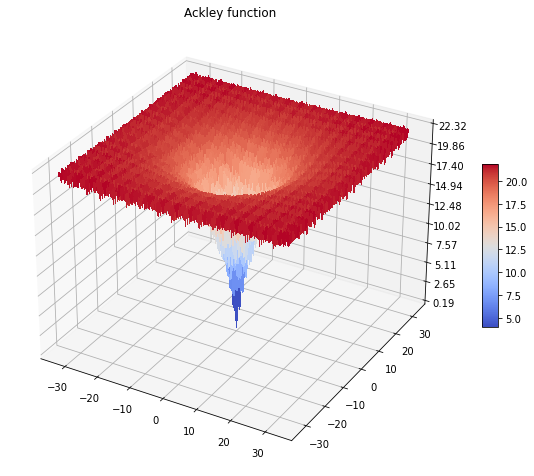

In [3]:
teneva.DemoFuncAckley(d=2).plot()

### Class `DemoFuncGrienwank`

Grienwank function for demo and tests.

In [4]:
X = np.array([
    [0., 0., 0.],
    [1., 1., 1.],
    [2., 2., 2.],
    [3., 3., 3.],
])
Func = teneva.DemoFuncGrienwank(d=X.shape[1])
print(Func.comp(X))
print(Func.calc(X[0]), Func.calc(X[-1]))

[0.         0.65656774 1.02923026 1.08990201]
0.0 1.0899020113755438


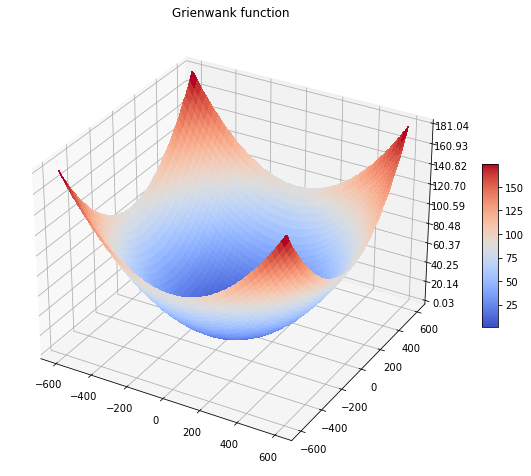

In [5]:
teneva.DemoFuncGrienwank(d=2).plot()

### Class `DemoFuncMichalewicz`

Michalewicz function for demo and tests.

In [6]:
X = np.array([
    [0., 0., 0.],
    [1., 1., 1.],
    [2., 2., 2.],
    [3., 3., 3.],
])
Func = teneva.DemoFuncMichalewicz(d=X.shape[1])
print(Func.comp(X))
print(Func.calc(X[0]), Func.calc(X[-1]))

[-0.00000000e+00 -1.45382977e-02 -3.70232531e-01 -3.26333212e-04]
-0.0 -0.000326333211876712


In [7]:
Func = teneva.DemoFuncMichalewicz(d=2)
x = np.array([2.2, 1.57])
print(Func.calc(x))

-1.801140718473825


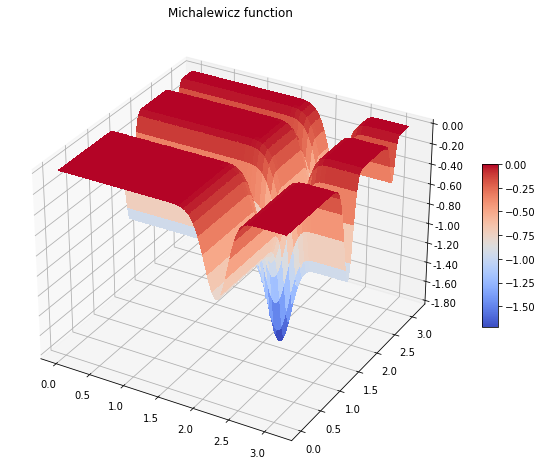

In [8]:
teneva.DemoFuncMichalewicz(d=2).plot()

### Class `DemoFuncPiston`

Piston function for demo and tests.

In [9]:
Func = teneva.DemoFuncPiston()
X_spec = (Func.a + Func.b) / 2
X_spec = X_spec.reshape(1, -1)
print(Func.comp(X_spec))
print(Func.calc(X_spec[0]))

[0.46439702]
0.4643970224718025


### Class `DemoFuncRastrigin`

Rastrigin function for demo and tests.

In [10]:
X = np.array([
    [0., 0., 0.],
    [1., 1., 1.],
    [2., 2., 2.],
    [3., 3., 3.],
])
Func = teneva.DemoFuncRastrigin(d=X.shape[1])
print(Func.comp(X))
print(Func.calc(X[0]), Func.calc(X[-1]))

[ 0.  3. 12. 27.]
0.0 27.0


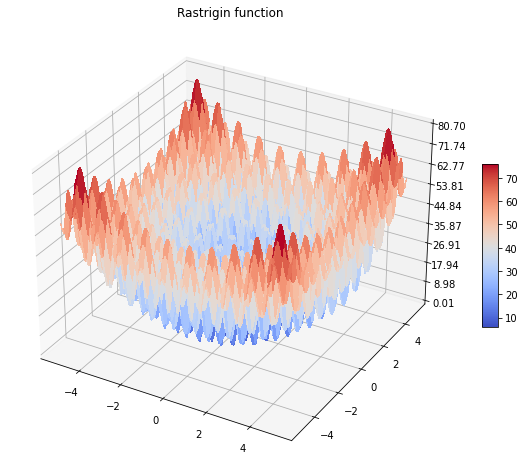

In [11]:
teneva.DemoFuncRastrigin(d=2).plot()

### Class `DemoFuncRosenbrock`

Rosenbrock function for demo and tests.

In [12]:
X = np.array([
    [0., 0., 0.],
    [1., 1., 1.],
    [2., 2., 2.],
    [3., 3., 3.],
])
Func = teneva.DemoFuncRosenbrock(d=X.shape[1])
print(Func.comp(X))
print(Func.calc(X[0]), Func.calc(X[-1]))

[2.000e+00 0.000e+00 8.020e+02 7.208e+03]
2.0 7208.0


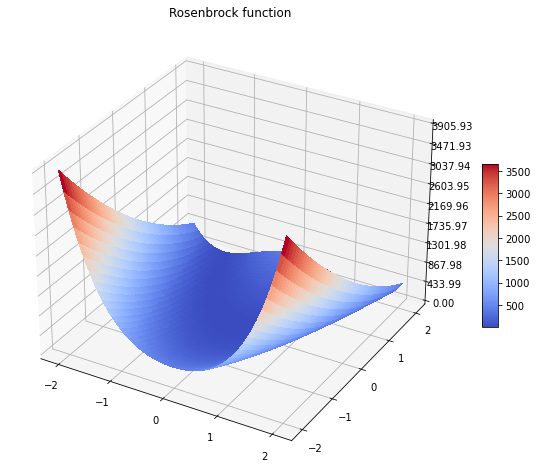

In [13]:
teneva.DemoFuncRosenbrock(d=2).plot()

### Class `DemoFuncSchwefel`

Schwefel function for demo and tests.

In [14]:
X = np.array([
    [0., 0., 0.],
    [1., 1., 1.],
    [2., 2., 2.],
    [3., 3., 3.],
])
Func = teneva.DemoFuncSchwefel(d=X.shape[1])
print(Func.comp(X))
print(Func.calc(X[0]), Func.calc(X[-1]))

[1256.9487     1254.42428705 1251.02210432 1248.0654602 ]
1256.9487 1248.0654601950866


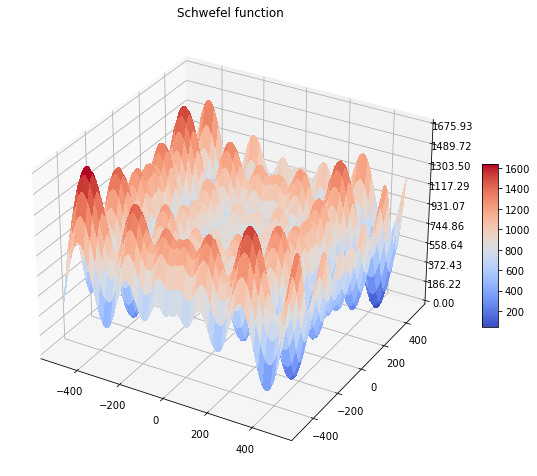

In [15]:
teneva.DemoFuncSchwefel(d=2).plot()

In [18]:
a = np.array([-2., -3., -4.])
b = np.array([+2., +3., +4.])
a + (b - a) * np.random.uniform()

array([0.92797577, 1.39196365, 1.85595153])

---